In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import polars as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

/home/ss/miniconda3/envs/optiver/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess(df: pd.DataFrame):
    df = pl.from_pandas(df)
    new_features1 = [
        (pl.col('date_id') % 5).alias('day_of_week'),
        (pl.col('imbalance_buy_sell_flag') + 1).alias('imbalance_buy_sell_flag'),
        (pl.col('ask_price') - pl.col('bid_price')).alias('diff_ask_price_bid_price'),
        (pl.col('ask_price') - pl.col('reference_price')).alias('diff_ask_price_reference_price'),
        (pl.col('bid_price') - pl.col('reference_price')).alias('diff_bid_price_reference_price'),
        (pl.col('ask_price') - pl.col('wap')).alias('diff_ask_price_wap'),
        (pl.col('bid_price') - pl.col('wap')).alias('diff_bid_price_wap'),
        (pl.col('far_price') - pl.col('near_price')).alias('diff_far_price_near_price'),
        (pl.col('far_price') - pl.col('reference_price')).alias('diff_far_price_reference_price'),
        (pl.col('near_price') - pl.col('reference_price')).alias('diff_near_price_reference_price'),
        (pl.col('ask_size') - pl.col('bid_size')).alias('diff_ask_size_bid_size'),
        (pl.col('ask_size') - pl.col('matched_size')).alias('diff_ask_size_matched_size'),
        (pl.col('bid_size') - pl.col('matched_size')).alias('diff_bid_size_matched_size'),
        (pl.col('imbalance_size') - pl.col('matched_size')).alias('diff_imbalance_size_matched_size'),
        (pl.col('ask_price') + pl.col('bid_price')).alias('sum_ask_price_bid_price'),
        (pl.col('far_price') + pl.col('near_price')).alias('sum_far_price_near_price'),
        (pl.col('ask_size') + pl.col('bid_size')).alias('sum_ask_size_bid_size'),
        (pl.col('bid_size') * pl.col('ask_price') / (pl.col('bid_size') + pl.col('ask_size'))).alias('wap_factor1'),
        # (pl.col('ask_size') * pl.col('bid_price') / (pl.col('bid_size') + pl.col('ask_size'))).alias('wap_factor2'),
        # (pl.col('near_price') / pl.col('far_price')).alias('div_near_price_far_price'),

        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('reference_price') - pl.col('bid_price'))).alias('feature1'), 
        # ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature2'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('bid_price') - pl.col('reference_price'))).alias('feature3'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature4'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('bid_price') - pl.col('wap'))).alias('feature5'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature6'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('reference_price') - pl.col('ask_price'))).alias('feature7'),
        # ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature8'),
        # ((pl.col('bid_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature9'),
        ((pl.col('bid_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature10'),
        ((pl.col('reference_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature11'),
        ((pl.col('reference_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature12'),

        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('matched_size') - pl.col('bid_size'))).alias('feature13'), 
        # ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('imbalance_size') - pl.col('bid_size'))).alias('feature14'), 
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('bid_size') - pl.col('imbalance_size'))).alias('feature15'), 
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('imbalance_size') - pl.col('matched_size'))).alias('feature16'), 
        # ((pl.col('ask_size') - pl.col('imbalance_size')) / (pl.col('bid_size') - pl.col('imbalance_size'))).alias('feature17'), 
        ((pl.col('ask_size') - pl.col('imbalance_size')) / (pl.col('matched_size') - pl.col('imbalance_size'))).alias('feature18'),
        ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('matched_size') - pl.col('ask_size'))).alias('feature19'),
        # ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('imbalance_size') - pl.col('ask_size'))).alias('feature20'),
        ((pl.col('bid_size') - pl.col('matched_size')) / (pl.col('imbalance_size') - pl.col('matched_size'))).alias('feature21'),
        ((pl.col('bid_size') - pl.col('imbalance_size')) / (pl.col('matched_size') - pl.col('imbalance_size'))).alias('feature22'),
        ((pl.col('matched_size') - pl.col('ask_size')) / (pl.col('imbalance_size') - pl.col('ask_size'))).alias('feature23'),
        ((pl.col('matched_size') - pl.col('bid_size')) / (pl.col('imbalance_size') - pl.col('bid_size'))).alias('feature24'),

        (pl.col('bid_price') / pl.col('ask_price')).alias('feature25'),
        (pl.col('reference_price') / pl.col('ask_price')).alias('feature26'),
        # (pl.col('wap') / pl.col('ask_price')).alias('feature27'),
        (pl.col('reference_price') / pl.col('bid_price')).alias('feature28'),
        # (pl.col('wap') / pl.col('bid_price')).alias('feature29'),

        # (pl.col('bid_size') / pl.col('ask_size')).alias('feature30'),
        (pl.col('ask_size') / pl.col('matched_size')).alias('feature31'),
        (pl.col('bid_size') / pl.col('matched_size')).alias('feature32'),
        (pl.col('imbalance_size') / pl.col('matched_size')).alias('feature33'),
        (pl.col('ask_size') / pl.col('imbalance_size')).alias('feature34'),
        # (pl.col('bid_size') / pl.col('imbalance_size')).alias('feature35'),

        # ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('ask_price') + pl.col('bid_price'))).alias('feature36'),
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('ask_price') + pl.col('reference_price'))).alias('feature37'),
        # ((pl.col('bid_price') - pl.col('reference_price')) / (pl.col('bid_price') + pl.col('reference_price'))).alias('feature38'),
        # ((pl.col('ask_price') - pl.col('wap')) / (pl.col('ask_price') + pl.col('wap'))).alias('feature39'),
        # ((pl.col('bid_price') - pl.col('wap')) / (pl.col('bid_price') + pl.col('wap'))).alias('feature40'),
        ((pl.col('reference_price') - pl.col('wap')) / (pl.col('reference_price') + pl.col('wap'))).alias('feature41'),

        # ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size'))).alias('feature42'),
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('ask_size') + pl.col('matched_size'))).alias('feature43'),
        ((pl.col('bid_size') - pl.col('matched_size')) / (pl.col('bid_size') + pl.col('matched_size'))).alias('feature44'),
        # ((pl.col('ask_size') - pl.col('imbalance_size')) / (pl.col('ask_size') + pl.col('imbalance_size'))).alias('feature45'),
        # ((pl.col('bid_size') - pl.col('imbalance_size')) / (pl.col('bid_size') + pl.col('imbalance_size'))).alias('feature46'),
        ((pl.col('matched_size') - pl.col('imbalance_size')) / (pl.col('matched_size') + pl.col('imbalance_size'))).alias('feature47'),

        (pl.col('imbalance_size') * (pl.col('ask_price') - pl.col('bid_price'))).alias('feature48'),
        ((pl.col('ask_price') - pl.col('bid_price')) * (pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size'))).alias('feature49'),
        ((pl.col('ask_size') - pl.col('bid_size')) * (pl.col('far_price') - pl.col('bid_price'))).alias('feature50'),
    ]

    transform_features = [
        'imbalance_size',
        'reference_price',
        'matched_size',
        'far_price',
        'near_price',
        'bid_price',
        'bid_size',
        'ask_price',
        'ask_size',
        'wap',
        'diff_ask_price_bid_price',
        'diff_ask_price_reference_price',
        'diff_bid_price_reference_price',
        'diff_ask_price_wap',
        'diff_bid_price_wap',
        'diff_far_price_near_price',
        'diff_far_price_reference_price',
        'diff_near_price_reference_price',
        'diff_ask_size_bid_size',
        'diff_ask_size_matched_size',
        'diff_bid_size_matched_size',
        'diff_imbalance_size_matched_size',
        'sum_ask_price_bid_price',
        'sum_far_price_near_price', 
        'wap_factor1',
        'wap_factor2',
        #'diff_wap_factor1_wap_factor2',
        'feature1',
        'feature2',
        'feature3',
        'feature4',
        'feature5',
        'feature6',
        'feature7',
        'feature8',
        'feature9',
        'feature10',
        'feature11',
        'feature12',
        'feature13',
        'feature14',
        'feature15',
        'feature16',
        'feature17',
        'feature18',
        'feature19',
        'feature20',
        'feature21',
        'feature22',
        'feature23',
        'feature24',
        'feature25',
        'feature26',
        'feature27',
        'feature28',
        'feature29',
        'feature30',
        'feature31',
        'feature32',
        'feature33',
        'feature34',
        'feature35',
        'feature36',
        'feature37',
        'feature38',
        'feature39',
        'feature40',
        'feature41',
        'feature42',
        'feature43',
        'feature44',
        'feature45',
        'feature46',
        'feature47',
        'feature48',
        'feature49',
        'feature50',
    ]

    new_features2 = [
        ((pl.col(feature) - pl.col(feature).quantile(0.5)) / (pl.col(feature).quantile(0.75) - pl.col(feature).quantile(0.25)))
        .over(['date_id', 'seconds_in_bucket'])
        .alias(f'robust_scaled_{feature}_over_stocks')
        for feature in transform_features
    ]

    new_features4 = [
        pl.col('wap').mean().over(['date_id', 'seconds_in_bucket']).alias(f'mean_wap_over_stocks'),
    ]
    
    df = (
        df
        .with_columns(new_features1)
        #.with_columns(new_features2)
        .drop(['row_id'])
        .to_pandas()
    )
    return df

In [3]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['time_id'], inplace=True)
train_df = preprocess(train_df)
train_df = train_df.dropna(subset=['target'])
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,day_of_week,diff_ask_price_bid_price,diff_ask_price_reference_price,diff_bid_price_reference_price,diff_ask_price_wap,diff_bid_price_wap,diff_far_price_near_price,diff_far_price_reference_price,diff_near_price_reference_price,diff_ask_size_bid_size,diff_ask_size_matched_size,diff_bid_size_matched_size,diff_imbalance_size_matched_size,sum_ask_price_bid_price,sum_far_price_near_price,sum_ask_size_bid_size,wap_factor1,feature1,feature3,feature4,feature5,feature6,feature7,feature10,feature11,feature12,feature13,feature15,feature16,feature18,feature19,feature21,feature22,feature23,feature24,feature25,feature26,feature28,feature31,feature32,feature33,feature34,feature37,feature41,feature43,feature44,feature47,feature48,feature49,feature50
0,0,0,0,3180602.69,2,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0.000214,0.000214,0.000000,0.000026,-0.000188,NaN,NaN,NaN,-52158.47,-13371783.61,-13319625.14,-10199673.95,1.999838,NaN,69144.53,0.877193,inf,inf,1.138298,-0.138298,-0.138298,1.000000,1.000000,8.230769,0.000000,-0.003916,4.285895,1.311001,-0.311001,0.003901,1.305887,-0.305887,4.215423,4.269177,0.999786,0.999786,1.000000,0.000635,0.004533,0.237708,0.002670,0.000107,-0.000094,-0.998731,-0.990975,0.615890,680.648976,-0.000161,NaN
1,1,0,0,166603.91,0,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0.000764,0.000764,0.000000,0.000660,-0.000104,NaN,NaN,NaN,17372.05,-1621609.16,-1638981.21,-1475610.34,2.000556,NaN,23838.13,0.135714,inf,inf,7.346154,-6.346154,-6.346154,1.000000,1.000000,1.157576,0.000000,0.010599,9.925938,1.098941,-0.098941,-0.010713,1.110714,-0.110714,11.107002,10.032273,0.999237,0.999237,1.000000,0.012547,0.001969,0.101451,0.123677,0.000382,-0.000052,-0.975217,-0.996070,0.815787,127.285387,0.000557,NaN
2,2,0,0,302879.87,0,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0.000895,0.000737,-0.000158,0.000298,-0.000597,NaN,NaN,NaN,-18961.00,-1800373.03,-1781412.03,-1516488.16,1.999701,NaN,56951.00,0.666666,5.664557,-4.664557,1.678815,-0.499162,-0.678815,1.214383,1.359909,2.473154,0.264657,-0.010644,6.795813,1.187199,-0.187199,0.010532,1.174696,-0.174696,6.341913,6.724241,0.999105,0.999263,1.000158,0.010440,0.020862,0.166475,0.062715,0.000369,-0.000220,-0.979335,-0.959128,0.714567,271.077484,-0.000298,NaN
3,3,0,0,11917682.27,0,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0.000215,0.000043,-0.000172,0.000214,-0.000001,NaN,NaN,NaN,476707.50,-17910713.22,-18387420.72,-6472063.35,2.000213,NaN,481357.30,0.004831,1.250000,-0.250000,-0.251462,-214.000000,1.251462,5.000000,-0.005848,0.200935,172.000000,0.025926,1.503162,2.767388,-1.767388,-0.026616,2.841045,-1.841045,1.565807,1.543170,0.999785,0.999957,1.000172,0.026049,0.000126,0.648061,0.040195,0.000021,0.000085,-0.949225,-0.999747,0.213547,2562.301688,0.000213,NaN
4,4,0,0,447549.96,0,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0.000622,0.000484,-0.000138,0.000016,-0.000606,NaN,NaN,NaN,-16051.44,-17860180.85,-17844129.41,-17413064.99,1.999410,NaN,16919.64,0.974359,4.507246,-3.507246,1.034188,-0.026403,-0.034188,1.285124,1.294872,30.250000,0.227723,-0.000900,41.432742,1.025677,-0.025677,0.000899,1.024755,-0.024755,39.945308,41.395505,0.999378,0.999516,1.000138,0.000024,0.000923,0.025058,0.000970,0.000242,-0.000234,-0.999951,-0.998156,0.951109,278.376075,-0.000590,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,0,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,

## train lightgbm models using cross validation

In [4]:
def train(
        dataset: pd.DataFrame,
        outputs_dir: pathlib.Path,
    ):
    
    target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
    feature_columns = [col for col in dataset.columns if col not in ['date_id', 'target']]
    days= np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    best_param_records = {}
    best_value_records = {}
    history = {
        'train_mae': [],
        'valid_mae': [],
        'test_mae': [],
    }

    step = 480 // 6
    test_days = days[-step:]
    test_X = dataset.query('date_id in @test_days')[feature_columns]
    test_y = dataset.query('date_id in @test_days')[target_columns]

    kfold = TimeSeriesSplit(n_splits=4, max_train_size=step, test_size=step, gap=0)

    for k, (train_indices, valid_indices) in enumerate(kfold.split(days[:-step])):
        train_days = days[train_indices]
        valid_days = days[valid_indices]
        print(f'fold {k+1}')
        print(train_days)
        print(valid_days)
        print(test_days)
        
        plot_time(days, train_days, valid_days, test_days)
        
        train_X = dataset.query('date_id in @train_days')[feature_columns]
        train_y = dataset.query('date_id in @train_days')[target_columns]
        valid_X = dataset.query('date_id in @valid_days')[feature_columns]
        valid_y = dataset.query('date_id in @valid_days')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        print(f'test_X.shape: {test_X.shape}, test_y.shape: {test_y.shape}')
        
        objective = Objective(train_X, train_y['target'], valid_X, valid_y['target'])
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study.optimize(objective, n_trials=2)

        best_params = study.best_params
        add_params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'seed': 42,
        }
        best_params.update(add_params)
        
        [print(f'{k}: {v}') for k, v in best_params.items()]
        print(f'best value: {study.best_value}')

        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        train_dataset = lgb.Dataset(
            train_X,
            train_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )

        valid_dataset = lgb.Dataset(
            valid_X,
            valid_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )
        
        model = lgb.train(
            params=best_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
        )
        model.save_model(
            outputs_dir.joinpath(f'lightgbm_optuna_fold{k+1}.txt'),
            num_iteration=model.best_iteration
        )
        
        best_params['num_boost_round'] = model.best_iteration
        best_param_records[f'fold{k+1}'] = best_params
        best_value_records[f'fold{k+1}'] = study.best_value

        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)

        train_pred = model.predict(train_X, num_iteration=model.best_iteration)
        valid_pred = model.predict(valid_X, num_iteration=model.best_iteration)
        test_pred = model.predict(test_X, num_iteration=model.best_iteration)

        test_y[f'regression_fold{k+1}'] = test_pred


        history['train_mae'].append(mean_absolute_error(train_y['target'], train_pred))
        history['valid_mae'].append(mean_absolute_error(valid_y['target'], valid_pred))
        history['test_mae'].append(mean_absolute_error(test_y['target'], test_pred))
        
        del objective, study
        del train_X, train_y, train_dataset, valid_dataset, model, fimp
        del train_pred, valid_pred, test_pred
        gc.collect()

    del valid_X, valid_y, test_X
    gc.collect()

    history = pd.DataFrame.from_dict(history)
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    
    test_y['regression'] = test_y[[f'regression_fold{k+1}' for k in range(4)]].mean(axis=1)
    test_y_mae = mean_absolute_error(test_y['target'], test_y['regression'])
    print(f'test_y mae: {test_y_mae:.4f}')
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'best_param_records': best_param_records,
                'best_value_records': best_value_records,
                'test_y rmse': test_y_mae,
            },
            f,
            default_flow_style=False
        )
    return history, test_y, fimps, best_param_records


class Objective:
    def __init__(self, train_X, train_y, valid_X, valid_y):
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y

    def __call__(self, trial):
        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'learning_rate': trial.suggest_float('learning_rate', 1e-03, 1e-01),
            'seed': 42,
            'max_depth':  trial.suggest_int('max_depth', 3, 10),
            # 'num_leaves': 256,
            # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            # 'feature_fraction': trial.suggest_float('feature_fraction_bynode', 0.4, 1.0),
            # 'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0.4, 1.0),
            #'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 10),
            #'bagging_fraction': 0.6,
            'verbose': -1,
        }
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0),
        ]
        
        train_dataset = lgb.Dataset(self.train_X, self.train_y)
        valid_dataset = lgb.Dataset(self.valid_X, self.valid_y)

        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
        )

        preds = model.predict(self.valid_X, num_iteration=model.best_iteration)
        mae = mean_absolute_error(preds, self.valid_y)

        del params, callbacks, train_dataset, valid_dataset, model, preds
        gc.collect()

        return mae
    

def plot_time(all_time, train_time, valid_time, test_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid+test', height=0.6, width=[len(train_time), len(valid_time), len(test_time)],
            left=[train_time.min(), valid_time.min(), test_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2, test_time.min()+len(test_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [f'all\n{len(all_time)}', f'train\n{len(train_time)}', f'valid\n{len(valid_time)}', f'test\n{len(test_time)}']
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), valid_time.min(), test_time.min(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

fold 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]
[ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159]
[400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453
 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471
 472 473 474 475 476 477 478 479]


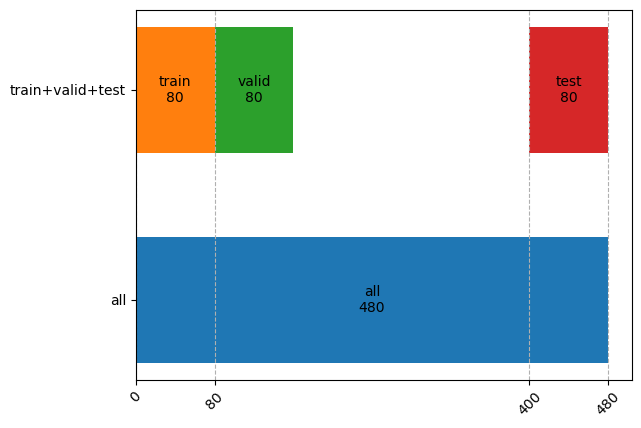

[I 2023-11-19 20:32:59,901] A new study created in memory with name: no-name-5bcac6ea-f8bb-4add-9390-b77ff6e5006a


train_X.shape: (850984, 63), train_y.shape: (850984, 4)
valid_X.shape: (866305, 63), valid_y.shape: (866305, 4)
test_X.shape: (879999, 63), test_y.shape: (879999, 4)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[634]	train's l1: 5.20855	valid's l1: 7.28988
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[342]	train's l1: 5.20861	valid's l1: 7.29128
learning_rate: 0.03807947176588889
max_depth: 10
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 7.289877023317272
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052400 seconds.
You can set `force_col_wise=true` to 

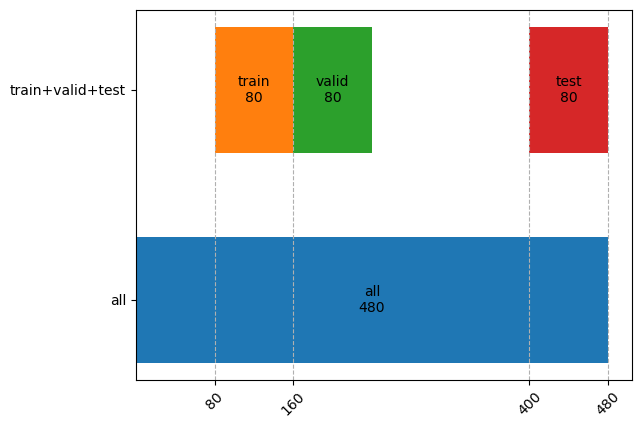

train_X.shape: (866305, 63), train_y.shape: (866305, 4)
valid_X.shape: (872740, 63), valid_y.shape: (872740, 4)
test_X.shape: (879999, 63), test_y.shape: (879999, 5)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[478]	train's l1: 7.17252	valid's l1: 6.77481
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	train's l1: 7.19763	valid's l1: 6.77556
learning_rate: 0.03807947176588889
max_depth: 10
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.774812495535826
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046612 seconds.
You can set `force_col_wise=true` to 

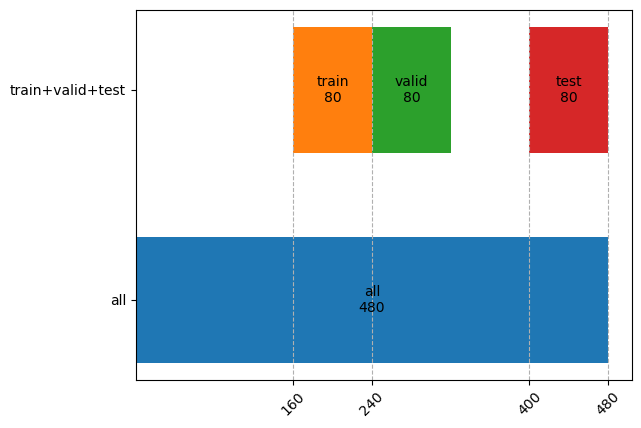

train_X.shape: (872740, 63), train_y.shape: (872740, 4)
valid_X.shape: (876975, 63), valid_y.shape: (876975, 4)
test_X.shape: (879999, 63), test_y.shape: (879999, 6)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[251]	train's l1: 6.70612	valid's l1: 6.06223
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	train's l1: 6.69483	valid's l1: 6.06273
learning_rate: 0.03807947176588889
max_depth: 10
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.062233079328056
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050190 seconds.
You can set `force_col_wise=true` to 

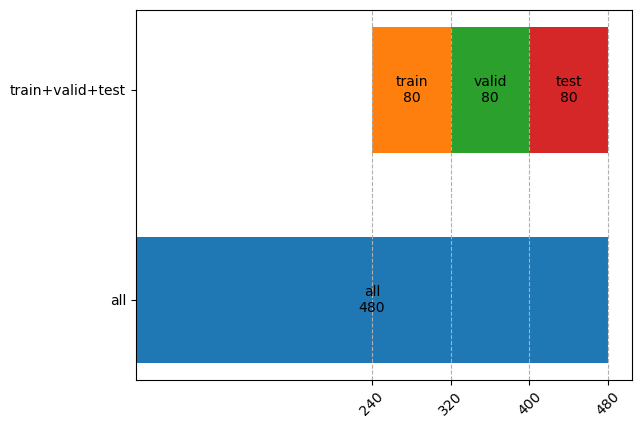

train_X.shape: (876975, 63), train_y.shape: (876975, 4)
valid_X.shape: (879889, 63), valid_y.shape: (879889, 4)
test_X.shape: (879999, 63), test_y.shape: (879999, 7)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[439]	train's l1: 5.97351	valid's l1: 6.34301
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	train's l1: 5.96842	valid's l1: 6.34375
learning_rate: 0.03807947176588889
max_depth: 10
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 6.343014518556358
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042969 seconds.
You can set `force_col_wise=true` to 

In [5]:
history, test_y, fimps, best_params_records = train(
    dataset=train_df,
    outputs_dir=outputs_dir_path,
)

,stock_id,date_id,seconds_in_bucket,target,regression_fold1,regression_fold2,regression_fold3,regression_fold4,regression
4346980,0,400,0,0.050068,0.892243,-0.090674,-0.339936,-0.563970,-0.025584
4346981,1,400,0,-10.010004,-1.561558,-2.278369,0.684971,-2.398046,-1.388251
4346982,2,400,0,7.070303,3.661774,5.237916,4.820964,3.899424,4.405020
4346983,3,400,0,3.780127,1.823182,2.601000,2.080207,2.616491,2.280220
4346984,4,400,0,1.590252,-2.963932,-3.583232,-3.224839,-2.522458,-3.073615
...,...,...,...,...,...,...,...,...,...
5226975,195,479,540,1.599789,0.585847,0.302942,0.747883,0.059323,0.423999
5226976,196,479,540,-8.440018,1.294101,1.609782,1.956683,0.162228,1.255699
5226977,197,479,540,5.149841,-0.786291,-0.506504,-1.194404,-0.747670,-0.808717
5226978,198,479,540,-0.249743,-2.074160,-1.347692,-1.507848,-1.415042,-1.586185


,fold1,fold2,fold3,fold4,mean_fimps,std_fimps
diff_ask_price_reference_price,4710.255820,2825.861971,1494.902053,2094.996566,2781.504103,1396.267434
feature10,1456.115903,1070.596930,272.030799,8338.940260,2784.420973,3735.700564
diff_bid_price_wap,3322.019436,3158.972205,1173.302985,3600.896472,2813.797774,1108.780435
feature34,3558.609337,2587.162242,2059.122152,3431.002680,2908.974103,711.887394
feature25,3499.126104,3325.940722,1857.787312,2980.950977,2915.951279,737.590709
feature28,3910.955584,3384.066114,2711.742043,2405.766369,3103.132527,676.019685
feature15,4744.871146,3309.385910,1352.890297,3215.492313,3155.659916,1390.777028
diff_bid_price_reference_price,3769.120992,3561.537003,2271.902607,3064.656072,3166.804169,665.803426
feature16,4366.512677,3399.840781,1831.738904,3435.942447,3258.508702,1051.158465
diff_ask_price_wap,3719.846474,3099.746837,4076.776303,3224.435508,3530.201280,452.214290


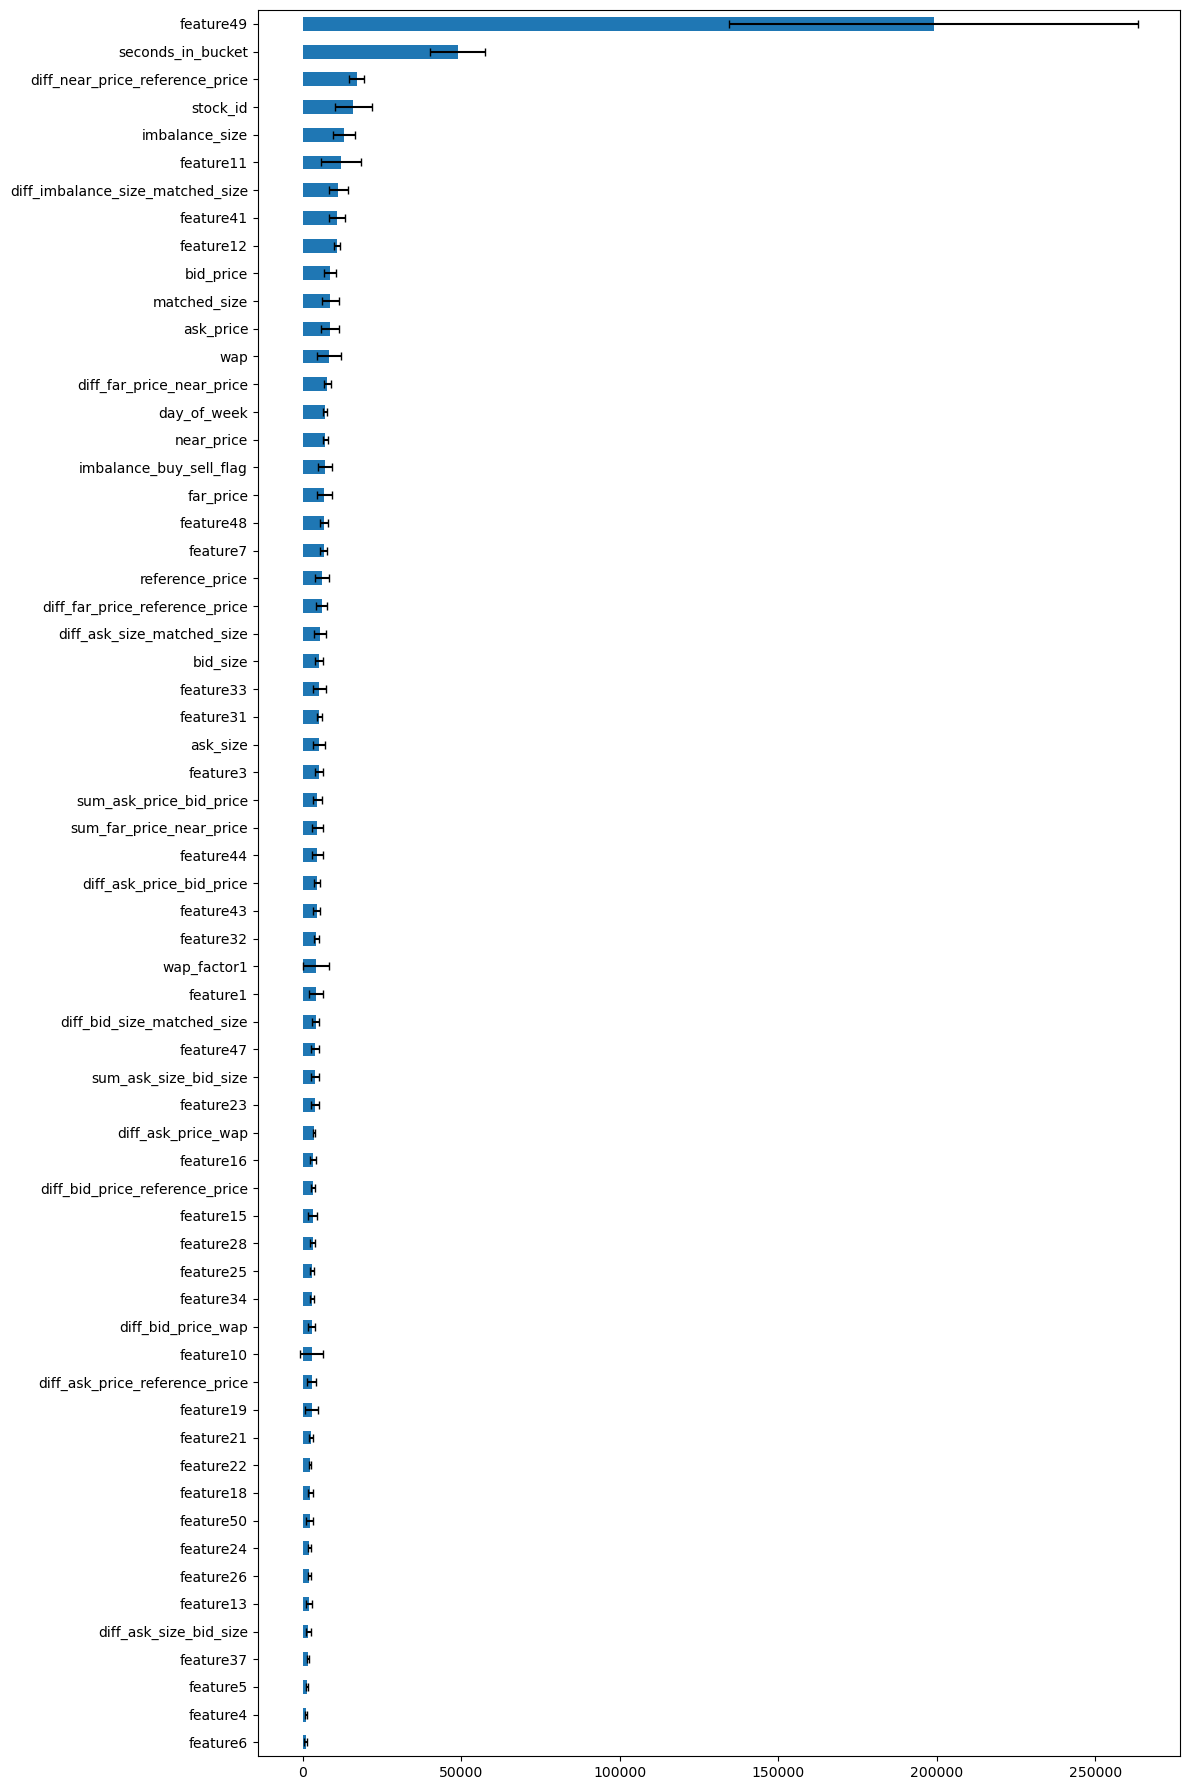

Index(['feature6', 'feature4', 'feature5', 'feature37',
       'diff_ask_size_bid_size', 'feature13', 'feature26'],
      dtype='object')

In [6]:
display(test_y)
display(fimps.tail(50))

_, ax = plt.subplots(figsize=(12, 18))
fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3, ax=ax)
plt.tight_layout()
plt.show()

fimps_q10 = fimps['mean_fimps'].quantile(q=0.1)
display(fimps.query('mean_fimps < @fimps_q10').index)

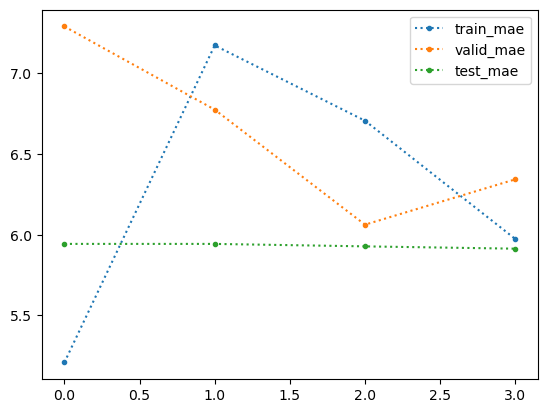

In [7]:
history.plot(marker='.', linestyle=':')
plt.show()

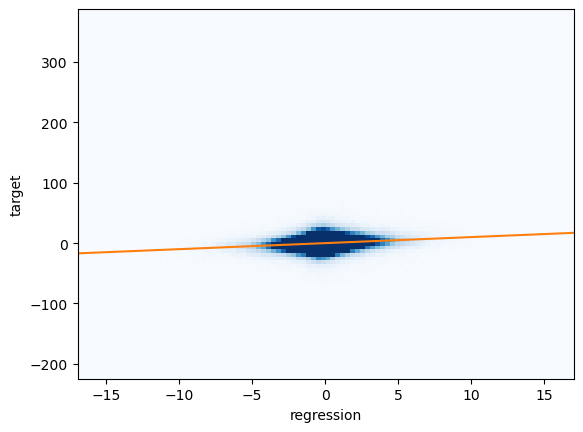

correlation coeeficient: 0.1582


In [8]:
_, ax = plt.subplots()
ax.hist2d(test_y['regression'], test_y['target'], bins=100, cmap='Blues', vmax=1e+03)
ax.plot([-100, 100], [-100, 100], color='tab:orange')
ax.set_xlabel('regression')
ax.set_ylabel('target')
plt.show()

r = np.corrcoef(test_y['regression'], test_y['target'])
print(f'correlation coeeficient: {r[0, 1]:.4f}')

## train lightgbm model using all data

In [9]:
best_params = pd.DataFrame(best_params_records)
display(best_params)

new_best_params = {}
for idx in best_params.index:
    if best_params.loc[idx].nunique() > 1:
        new_best_params[idx] = best_params.loc[idx].median().item()
    else:
        new_best_params[idx] = best_params.loc[idx].unique().item()
    if isinstance(best_params.loc[idx].iloc[0], int):
        new_best_params[idx] = int(new_best_params[idx])

num_boost_round = new_best_params.pop('num_boost_round')
print(new_best_params)

,fold1,fold2,fold3,fold4
learning_rate,0.038079,0.038079,0.038079,0.038079
max_depth,10,10,10,10
task,train,train,train,train
boosting_type,gbdt,gbdt,gbdt,gbdt
objective,mae,mae,mae,mae
metric,mae,mae,mae,mae
seed,42,42,42,42
num_boost_round,634,478,251,439


{'learning_rate': 0.03807947176588889, 'max_depth': 10, 'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mae', 'metric': 'mae', 'seed': 42}


In [10]:
target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
feature_columns = [col for col in train_df.columns if col not in ['date_id', 'target']]

callbacks = [
    lgb.log_evaluation(100),
]

train_dataset = lgb.Dataset(
    train_df[feature_columns],
    train_df[target_columns]['target'],
)

del train_df
gc.collect()

model = lgb.train(
    params=new_best_params,
    train_set=train_dataset,
    callbacks=callbacks,
    num_boost_round=num_boost_round,
)

model.save_model(
    outputs_dir_path.joinpath(f'lightgbm_trained_using_alldata.txt'),
    num_iteration=model.best_iteration
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.251627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15305
[LightGBM] [Info] Number of data points in the train set: 5237892, number of used features: 63
[LightGBM] [Info] Start training from score -0.060201
